# Transformer 구현

## Google SentencePiece 활용하여 Vocab 생성
1. character 단위로 Vocab 생성(자음-모음 단위 or 음절 단위)
생성 가능한 모든 글자를 전부 vocab으로 표현이 가능
하지만 각 단어의 고유한 의미를 표현하고 있는 것은 아니므로 좋은 성능 못낼 우려

2. space 단위로 Vocab 생성
한국어는 조사, 어미 등으로 인한 중복단어가 발생할 우려
책이, 책을, 책에 등과 같이 모든 경우의 수를 vocab으로 만들면 매우 커지게 되고 빈도수가 낮은 단어는 학습에 불리
그렇다고 일정 빈도 수를 설정해 놓으면 UNK 가 등장할 수도

3. 단어의 빈도 수를 계산해 subword 단위로 Vocab 생성
기계는 모든 단어를 학습할 수 없으므로 모르는 단어로 인해 문제를 푸는 데 이슈가 생기면 이를 'OOV(Out Of Vocabulary)' 문제라 함
이를 방지하기 위해 하나의 단어를 여러 subword 단위로 분리하여 단어를 인코딩, 임베딩 수행
이를 '서브워드 분리(subword segmenation)'라 하며 subword 단위로 나누는 토크나이저를 서브워드 토크나이저라 함
OOV를 해결하기 위해 대표 알고리즘인 'BPE(Byte Pair Encoding)'를 사용

Google이 제공하는 툴 중 sentencepiece를 활용함으로써 많은 vocab과 UNK 토큰에 대응

### BPE 실습

In [1]:
import re, collections
from IPython.display import display, Markdown, Latex

In [2]:
# BPE를 몇 회 수행할 지 설정
num_merges = 10

In [4]:
# BPE에 사용할 단어가 있을 때, BPE의 입력으로 사용하는 실제 단어 집합은 다음과 같다.
# '</w>'는 단어 맨 끝에 붙이는 특수 문자이며 각 단어는 글자(character) 단위로 분리한다.
dictionary = {
              'l o w </w>' : 5,
              'l o w e r </w>' : 2,
              'n e w e s t </w>':6,
              'w i d e s t </w>':3
             }

In [5]:
pairs = collections.defaultdict(int)
pairs

defaultdict(int, {})

In [6]:
# 가장 빈도수가 높은 uni-gram의 쌍을 하나의 uni-gram으로 통합하는 과정으로, num_merges 반복한다.
def get_stats(dictionary: dict) -> dict:
    # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)  # >>> pairs = defaultdict(int, {})
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    print('현재 pair들의 빈도수: ', dict(pairs))
    
    return pairs


def merge_dictionary(pair: dict, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))  # re.escape(str) : 영숫자가 아닌 모든 문자가 백 슬래시 인('\') 문자열을 반환
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    
    return v_out


bpe_codes = {}
bpe_codes_reverse = {}

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i+1)))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

### Iteration 1

현재 pair들의 빈도수:  {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

현재 pair들의 빈도수:  {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

현재 pair들의 빈도수:  {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

현재 pair들의 빈도수:  {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('l', 'o')
dictionary: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

현재 pair들의 빈도수:  {('lo', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('lo', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

현재 pair들의 빈도수:  {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('n', 'e')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

현재 pair들의 빈도수:  {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('ne', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('ne', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

현재 pair들의 빈도수:  {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('new', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('new', 'est</w>')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

현재 pair들의 빈도수:  {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('low', '</w>')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

현재 pair들의 빈도수:  {('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('w', 'i')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


In [7]:
'''
e와 s의 쌍은 초기 단어 집합에서 총 9회 등장
그러므로 es로 통합
그 다음으로는 es와 t의 쌍, est와 </w>의 쌍을 통합
빈도수가 가장 높은 순서대로 위 과정을 num_merges 반복했음
'''
print(bpe_codes)

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


### OOV에 대처

In [13]:
def get_pairs(word):
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char  # word = '최인서' 일 때, pairs = {('최','인')('인','서')}
    
    return pairs


def encode(orig):
    word = tuple(orig) + ('</w>',)  # tuple 끼리 구조를 합칠 수 있다. 단 값은 변동 없음
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))
    
    pairs = get_pairs(word)
    
    if not pairs:
        return orig
    
    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))
        print("bigrams in the word: {}".format(pairs))
        
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break
            
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
                
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # 특별 토큰인 </w>는 출력하지 않는다.
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

In [14]:
'''
'loki' 입력 시 현재 서브워드 단어집합에는 'lo'가 존재하므로, 'lo'는 유지하고 'k', 'i'는 분리시킨다.
'''
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('k', 'i'), ('l', 'o'), ('i', '</w>'), ('o', 'k')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')


__Iteration 2:__

bigrams in the word: {('lo', 'k'), ('i', '</w>'), ('k', 'i')}
candidate for merging: ('lo', 'k')


__Candidate not in BPE merges, algorithm stops.__

('lo', 'k', 'i')

### 말뭉치 만들기(한국어 위키)

In [15]:
import sentencepiece as spm
'''
1. input : 입력 corpus
2. prefix : 저장할 모델 이름
3. vocab_size : vocab 개수 (기본 8000에 스페셜 토큰 7개를 더해서 8007개)
4. max_sentence_length : 문장의 최대 길이
5. pad_id, pad_piece : pad token id, 값
6. unk_id, unk_piece: unknown token id, 값
7. bos_id, bos_piece: begin of sentence token id, 값
8. eos_id, eos_piece: end of sequence token id, 값
9. user_defined_symbols: 사용자 정의 토큰

skt kobert는 8000개의 vocab을 사용한다.
'''

corpus = "./kowiki.txt"
prefix = "kowiki"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./kowiki.txt --model_prefix=kowiki --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./kowiki.txt
  input_format: 
  model_prefix: kowiki
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  user_defined_symbols: [SEP]
  user_defined_symbols: [CLS]
  user_defined_symbols: [MASK]
  required_ch

In [16]:
# Vocab 테스트
import sentencepiece as spm

vocab_file = "./kowiki/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
  "겨울이 되어서 날씨가 무척 추워요.",
  "이번 성탄절은 화이트 크리스마스가 될까요?",
  "겨울에 감기 조심하시고 행복한 연말 되세요."
]
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    print(line)
    print(pieces)
    print(ids)
    print()

겨울이 되어서 날씨가 무척 추워요.
['▁겨울', '이', '▁되어', '서', '▁날', '씨', '가', '▁무', '척', '▁추', '워', '요', '.']
[3091, 3588, 601, 3602, 683, 4014, 3599, 108, 4193, 206, 3958, 3760, 3590]

이번 성탄절은 화이트 크리스마스가 될까요?
['▁이번', '▁성', '탄', '절', '은', '▁화', '이트', '▁크리스', '마', '스가', '▁될', '까', '요', '?']
[3224, 86, 3967, 3923, 3604, 264, 669, 1970, 3664, 780, 1450, 3794, 3760, 4245]

겨울에 감기 조심하시고 행복한 연말 되세요.
['▁겨울', '에', '▁감', '기', '▁조', '심', '하', '시', '고', '▁행', '복', '한', '▁연', '말', '▁되', '세', '요', '.']
[3091, 3591, 212, 3605, 53, 3832, 3596, 3613, 3600, 234, 3871, 3603, 61, 3823, 445, 3682, 3760, 3590]



## Vocab 활용한 텍스트 변환

In [43]:
import torch
import torch.nn as nn
import sentencepiece as spm

# vocab loading
vocab_file = "./kowiki/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])


## Embedding
- Transformer의 Embedding은 두 가지 Embedding을 합쳐서 사용

In [22]:
## Input Embedding
'''
입력 토큰을 vector 형태로 변환
inputs에 대한 embedding 값 input_embs를 계산
'''

n_vocab = len(vocab) # vocab count, 8007(8000 + 7)
d_hidn = 128 # hidden size
nn_emb = torch.nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


In [23]:
## Position Embedding
'''
1. 각 position별로 angle 값을 구한다.
2. 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구한다.
3. 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구한다.
'''
""" sinusoid position embedding """
import numpy as np

def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)  # np.power(a,b) : 값 a의 b제곱
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]
    
    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table    

(64, 128)


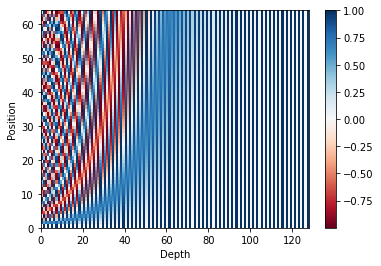

In [24]:
# position encoding 값 구하기
import matplotlib.pyplot as plt

n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()
# 각 position 별로 다른 값을 가짐을 확인할 수 있다.

In [27]:
'''
1. 위에서 구한 position encoding 값을 이용하여 position embedding을 생성, 학습하지 않으므로 freeze=True
2. 입력 inputs와 동일한 크기를 갖는 position을 계산
3. input 값 중 pad(0) 값을 찾음
4. position 값 중 pad 부분은 0으로 변환
5. position 값에 해당하는 embedding 값을 계산
'''

pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = torch.nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [29]:
'''
위의 결과로 보아 inputs의 pad(0) 위치에 positions 값도 pad(0)으로 변경되어 있다.
pos_embs(2,8,128)은 input_embs(2,8,128)와 shape이 동일하므로 이 둘을 더하면 Transformer의 input이 된다.
'''
input_sums = input_embs + pos_embs
input_sums.shape

torch.Size([2, 8, 128])

## Scaled Dot Product Attention

In [30]:
'''
입력값은 Q, K, V 그리고 attention mask로 구성되어 있다.
이때 K, V는 같은 값이어야 하며 Q,K,V가 모두 동일한 경우는 self-attention 이라 한다.
'''
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

print(attn_mask.size())
print(attn_mask[0])  # attn_mask 값은 pad(0) 부분만 True 이다.

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


In [31]:
# MatMul Q, K-Transpose(치환)
scores = torch.matmul(Q, K.transpose(-1, -2))

print(scores.size())
print(scores[0])  # 각 단어 상호간 가중치를 표현

torch.Size([2, 8, 8])
tensor([[166.5111,  71.2445,  70.1711,  47.2882,  53.4295,  51.3275,  50.3548,
          50.3548],
        [ 71.2445, 231.4675,  76.7528,  47.2865,  84.0712,  63.8822,  58.1213,
          58.1213],
        [ 70.1711,  76.7528, 188.0140,  47.0536,  68.8331,  69.9415,  47.1775,
          47.1775],
        [ 47.2882,  47.2865,  47.0536, 146.8650,  40.9054,  37.1201,  35.9969,
          35.9969],
        [ 53.4295,  84.0712,  68.8331,  40.9054, 222.3812,  80.0809,  67.9657,
          67.9657],
        [ 51.3275,  63.8822,  69.9415,  37.1201,  80.0809, 175.4418,  40.3228,
          40.3228],
        [ 50.3548,  58.1213,  47.1775,  35.9969,  67.9657,  40.3228, 192.9808,
         192.9808],
        [ 50.3548,  58.1213,  47.1775,  35.9969,  67.9657,  40.3228, 192.9808,
         192.9808]], grad_fn=<SelectBackward>)


In [32]:
# 가중치 편차를 줄이기 위한 scaling 진행
d_head = 64
scores = scores.mul_(1 / d_head ** 0.5)

print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[20.8139,  8.9056,  8.7714,  5.9110,  6.6787,  6.4159,  6.2944,  6.2944],
        [ 8.9056, 28.9334,  9.5941,  5.9108, 10.5089,  7.9853,  7.2652,  7.2652],
        [ 8.7714,  9.5941, 23.5018,  5.8817,  8.6041,  8.7427,  5.8972,  5.8972],
        [ 5.9110,  5.9108,  5.8817, 18.3581,  5.1132,  4.6400,  4.4996,  4.4996],
        [ 6.6787, 10.5089,  8.6041,  5.1132, 27.7976, 10.0101,  8.4957,  8.4957],
        [ 6.4159,  7.9853,  8.7427,  4.6400, 10.0101, 21.9302,  5.0403,  5.0403],
        [ 6.2944,  7.2652,  5.8972,  4.4996,  8.4957,  5.0403, 24.1226, 24.1226],
        [ 6.2944,  7.2652,  5.8972,  4.4996,  8.4957,  5.0403, 24.1226, 24.1226]],
       grad_fn=<SelectBackward>)


In [33]:
# mask를 한 부분이 -1e9로 매우 작은 값으로 변경(Masking)
scores.masked_fill_(attn_mask, -1e9)

print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.0814e+01,  8.9056e+00,  8.7714e+00,  5.9110e+00,  6.6787e+00,
          6.4159e+00, -1.0000e+09, -1.0000e+09],
        [ 8.9056e+00,  2.8933e+01,  9.5941e+00,  5.9108e+00,  1.0509e+01,
          7.9853e+00, -1.0000e+09, -1.0000e+09],
        [ 8.7714e+00,  9.5941e+00,  2.3502e+01,  5.8817e+00,  8.6041e+00,
          8.7427e+00, -1.0000e+09, -1.0000e+09],
        [ 5.9110e+00,  5.9108e+00,  5.8817e+00,  1.8358e+01,  5.1132e+00,
          4.6400e+00, -1.0000e+09, -1.0000e+09],
        [ 6.6787e+00,  1.0509e+01,  8.6041e+00,  5.1132e+00,  2.7798e+01,
          1.0010e+01, -1.0000e+09, -1.0000e+09],
        [ 6.4159e+00,  7.9853e+00,  8.7427e+00,  4.6400e+00,  1.0010e+01,
          2.1930e+01, -1.0000e+09, -1.0000e+09],
        [ 6.2944e+00,  7.2652e+00,  5.8972e+00,  4.4996e+00,  8.4957e+00,
          5.0403e+00, -1.0000e+09, -1.0000e+09],
        [ 6.2944e+00,  7.2652e+00,  5.8972e+00,  4.4996e+00,  8.4957e+00,
          5.0403e+00, -1.0000e+09, -1.0000e

In [34]:
# Softmax를 진행하므로써 가중치 값들이 확률값으로 변환됐고 masking 부분이 모두 0이 되었다.
attn_prob = torch.nn.Softmax(dim=-1)(scores)

print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[9.9999e-01, 6.7340e-06, 5.8884e-06, 3.3710e-07, 7.2636e-07, 5.5852e-07,
         0.0000e+00, 0.0000e+00],
        [2.0045e-09, 1.0000e+00, 3.9905e-09, 1.0032e-10, 9.9614e-09, 7.9859e-10,
         0.0000e+00, 0.0000e+00],
        [4.0057e-07, 9.1197e-07, 1.0000e+00, 2.2269e-08, 3.3888e-07, 3.8924e-07,
         0.0000e+00, 0.0000e+00],
        [3.9290e-06, 3.9282e-06, 3.8155e-06, 9.9999e-01, 1.7692e-06, 1.1023e-06,
         0.0000e+00, 0.0000e+00],
        [6.7321e-10, 3.1016e-08, 4.6170e-09, 1.4069e-10, 1.0000e+00, 1.8835e-08,
         0.0000e+00, 0.0000e+00],
        [1.8290e-07, 8.7858e-07, 1.8738e-06, 3.0971e-08, 6.6552e-06, 9.9999e-01,
         0.0000e+00, 0.0000e+00],
        [7.2458e-02, 1.9130e-01, 4.8708e-02, 1.2040e-02, 6.5482e-01, 2.0677e-02,
         0.0000e+00, 0.0000e+00],
        [7.2458e-02, 1.9130e-01, 4.8708e-02, 1.2040e-02, 6.5482e-01, 2.0677e-02,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>)


In [41]:
# MatMul attn_prob, V -> Q와 동일한 shape 값이 구해지며, 이는 V 값들이 attn_prob의 가중치를 이용해서 더해진 값이다.
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


In [2]:
# 위의 코드들은 하나의 Class로 구성
from torch import nn

""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
        
    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        
        attn_prob = nn.Softmax(dim=-1)(scores)
        
        context = torch.matmul(attn_prob, V)
        
        return context, attn_prob